In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm

data = pd.read_csv('train-data-cleaned.csv')
test = pd.read_csv('test-data-cleaned.csv')

# pop unwanted columns
data.pop('Unnamed: 0')
test.pop('Unnamed: 0')

df_y = data.pop('monthly_rent')
df_X = data

# this commented sections are for using OLS method to find the p-values, which derives from hypothesis testing,
# mainly for each column, and we reject those that breach alpha value, in this case alpha =0.1

df_X = sm.add_constant(df_X)
model = sm.OLS(df_y,df_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1140.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:38:56   Log-Likelihood:            -4.5799e+05
No. Observations:               60000   AIC:                         9.161e+05
Df Residuals:                   59944   BIC:                         9.166e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [20]:
# resulting columns that is insignificant to the variable we are testing , in this case it is monthly rent
col = ['longitude','t82usi','z74si','v03si','vc2si','u96si','u14si','u06si','s63si','s58si',
       'n2iusi','ken','grin','g13si',
       'ap4si','0799hk','n_shopping_malls_0.2_km','n_primary_schools_0.2_km',
       'n_shopping_malls_0.1_km','n_primary_schools_0.1_km','rent_approved_year']
df_X = df_X.drop(col,axis=1)
test= test.drop(col,axis=1)
model = sm.OLS(df_y,df_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1254.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:41:10   Log-Likelihood:            -4.5799e+05
No. Observations:               60000   AIC:                         9.161e+05
Df Residuals:                   59949   BIC:                         9.165e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [21]:
col2 = ['z25si','u11si','s51si','s08si','p15si','o39si','me8usi','maxn','m44usi'
       ,'k71usi','hmnsi','grab','g07si','flex','f34si','e5hsi','d05si','cjlusi','c52si','c07si'
       ,'buousi','bn4si','asln','1792hk']
df_X = df_X.drop(col2,axis=1)
test= test.drop(col2,axis=1)
model = sm.OLS(df_y,df_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     1896.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:41:14   Log-Likelihood:            -4.5802e+05
No. Observations:               60000   AIC:                         9.161e+05
Df Residuals:                   59966   BIC:                         9.164e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [22]:
col3 = ['c09si','a17usi']
df_X = df_X.drop(col3,axis=1)
test= test.drop(col3,axis=1)
model = sm.OLS(df_y,df_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     2019.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:41:17   Log-Likelihood:            -4.5803e+05
No. Observations:               60000   AIC:                         9.161e+05
Df Residuals:                   59968   BIC:                         9.164e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [23]:
# drop constant column as we do not need it for lgbm later on
df_X = df_X.drop('const',axis=1)

X_train, X_eval, y_train, y_eval = train_test_split(df_X,df_y,test_size=0.20,shuffle=True,random_state=20)

# this is to ensure we have same order of features for both test and train dataset
for v,t in zip(X_train.columns,test.columns):
    if v !=t :
        print('Columns are not in same order for test and data!')

In [41]:
# the commented sections below are to find best hyperparameters for light gradient boost model
def lgbm(reg_alpha = 0.1, reg_lambda = 0.05,subsample=0.4, colsample_bytree =0.5, learning_rate=0.01,
                  max_depth=25, min_child_samples = 10,
                  n_estimators =1200, num_leaves=31):
    lgbm_final = lgb.LGBMRegressor(subsample=subsample, colsample_bytree =colsample_bytree, learning_rate=learning_rate,
                  max_depth=max_depth, metric='rmse', min_child_samples = min_child_samples,
                  n_estimators =n_estimators , seed=42,num_leaves=num_leaves,reg_alpha =reg_alpha,
                                  reg_lambda=reg_lambda,verbose=-1)
    lgbm_final.fit(X_train, y_train)
    y_pred_test = lgbm_final.predict(X_eval)
    rmse = np.sqrt(mean_squared_error(y_eval, y_pred_test))
    return rmse


temp = []
lr = [0.1 , 0.5 , 0.01, 0.05,0.001 , 0.005, 0.0001]
result = {}
for l in lr:
    temp.append(lgbm(learning_rate=l))
result['lr'] = temp

temp = []
depth = [1, 10 , 15, 25, 35, 50, 100]
for d in depth:
    temp.append(lgbm(max_depth =d))
result['depth'] = temp    

temp = []
subsamples = [0.4,0.5,0.6,0.7,0.8,0.9,1]
for s in subsamples:
    temp.append(lgbm(subsample =s))
result['subsample'] = temp

temp = []
colsample_bytrees = [0.4,0.5,0.6,0.7,0.8,0.9,1]
for c in colsample_bytrees:
    temp.append(lgbm(colsample_bytree =c))
result['colsample_bytree'] = temp

temp = []
min_child_samples1 = [10,20,30,50,80,100,150]
for m in min_child_samples1:
    temp.append(lgbm(min_child_samples =m))
result['min_child_samples'] = temp

temp = []
n_estimator = [100,200,400,600,900,1200,2000]
for n in n_estimator:
    temp.append(lgbm(n_estimators=n))
result['n_estimators'] = temp

temp = []
num_leaf = [7,15,31,63,127,255,511]
for le in num_leaf:
    temp.append(lgbm(num_leaves =le))
result['num_leaves'] = temp

temp = []
reg_alphas = [0.1,0.5,0.01,0.05,0.001,0.005,0.0001]
for a in reg_alphas:
    temp.append(lgbm(reg_alpha =a))
result['reg_alpha'] = temp

temp = []
reg_lambdas = [0.1,0.5,0.01,0.05,0.001,0.005,0.0001]
for lam in reg_lambdas:
    temp.append(lgbm(reg_lambda =lam))
result['reg_lambda'] = temp

In [43]:
# this is used to get best RMSE out of all values, then using the best value to do another evaluation above, until we get the optimum values
for r in result:
    min = 1000
    index = 0
    for i in range(len(result[r])):
        if result[r][i] < min:
            min = result[r][i]
            index = i
    print(index,min)

2 478.891390725523
3 478.891390725523
0 478.891390725523
1 478.891390725523
0 478.891390725523
5 478.891390725523
2 478.891390725523
0 478.891390725523
3 478.891390725523


In [48]:
start = time.process_time()

# final model with best hyper-parameters
lgbm_final = lgb.LGBMRegressor(reg_alpha = 0.1, reg_lambda = 0.05,subsample=0.4, colsample_bytree =0.5, learning_rate=0.01,
                  max_depth=25, min_child_samples = 10,
                  n_estimators=1200, num_leaves=31, metric='rmse',seed=42,verbose=-1)
lgbm_final.fit(X_train, y_train)

# print time taken
print(time.process_time() - start)

# for getting training RMSE
y_pred_eval = lgbm_final.predict(X_eval)
print('RMSE: ',np.sqrt(mean_squared_error(y_eval, y_pred_eval)))

9.78125
RMSE:  478.891390725523


In [49]:
# predict and save
y_pred = lgbm_final.predict(test)

csv= {
    'Id' : list(range(len(test))),
    'Predicted' : y_pred
}
    
df = pd.DataFrame(csv)

df.to_csv('final+dropped_columns.csv',index=False)

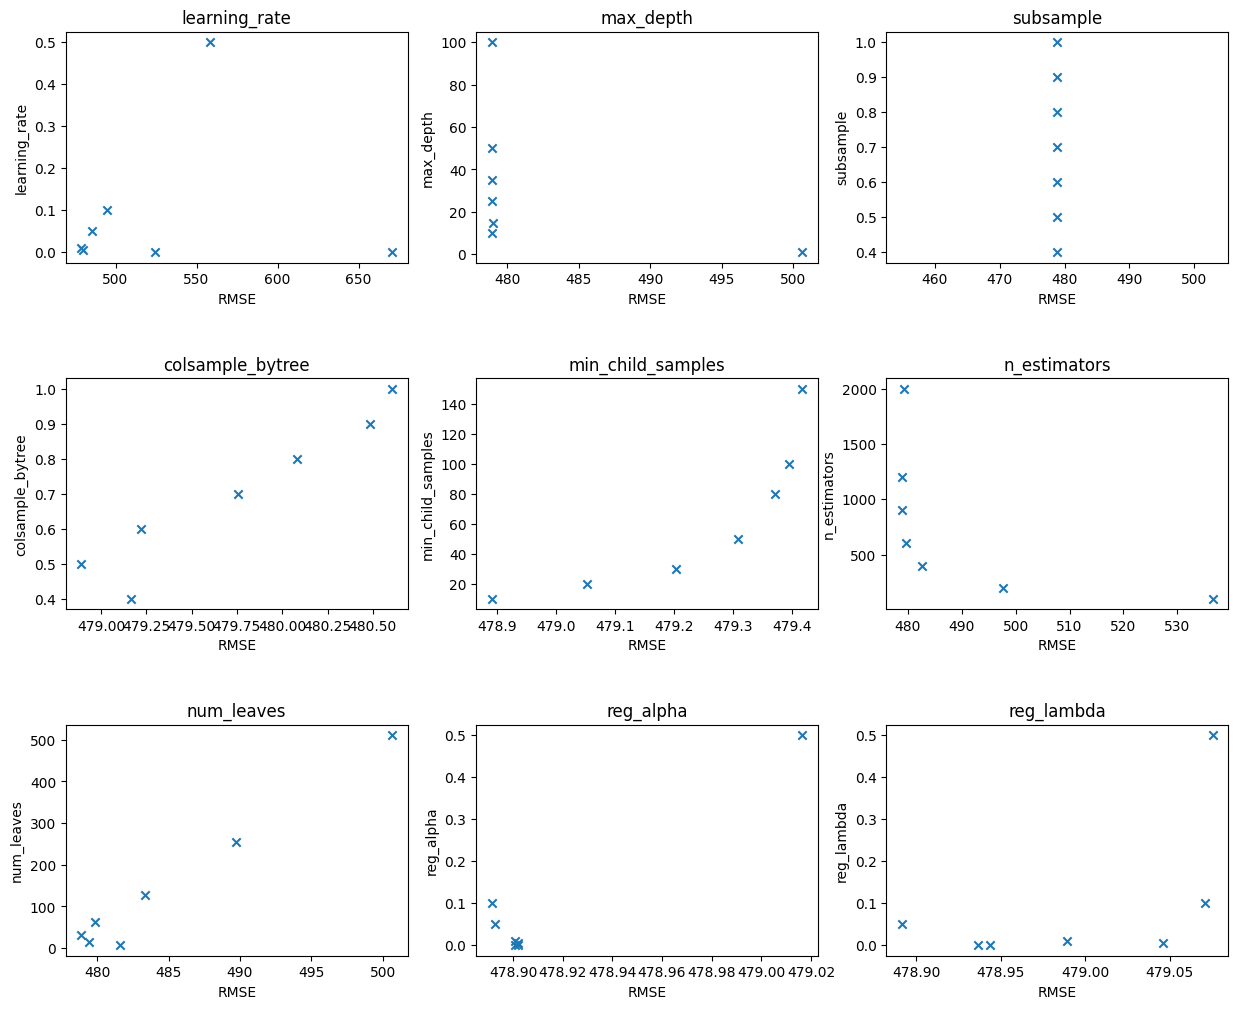

In [52]:
# for creating the graph if we do hyper-parameters selection
hp = [lr,depth,subsamples,colsample_bytrees,min_child_samples1,n_estimator,num_leaf,reg_alphas,reg_lambdas]

# Create subplots to visualize each hyperparameter against the performance
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

hyperparameters = [result['lr'], result['depth'], result['subsample'], result['colsample_bytree'],  result['min_child_samples'], result['n_estimators'], result['num_leaves'], result['reg_alpha'], result['reg_lambda']]
hyperparameter_names = ['learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'min_child_samples', 'n_estimators', 'num_leaves', 'reg_alpha', 'reg_lambda']

for i in range(len(hyperparameters)):
    ax = axes[i // 3, i % 3]
    ax.scatter(hyperparameters[i], hp[i], marker='x', alpha=1)
    ax.set_xlabel('RMSE')
    ax.set_ylabel((hyperparameter_names[i]))
    ax.set_title(hyperparameter_names[i])

plt.show()